In [66]:
import csv

import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

RANDOM_SEED = 42

# Specify each path

In [67]:
dataset_testGood = 'camera_data_test/hand_landmarks_goodTest.csv'
dataset_testDark = 'camera_data_test/hand_landmarks_darkTest.csv'
dataset_hand_after_sign= 'camera_data_test/hand_landmarks_hand_behind_hand.csv'
model_save_path = 'camera_classifier.keras'
tflite_save_path = 'camera_classifier.tflite'

# Set number of classes

In [68]:
NUM_CLASSES = 24

# Dataset reading

In [69]:
# Directory containing CSV files
directory = 'camera_data'

# Initialize an empty list to store data from all files
data = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        # Load data from each file and append to the list
        data.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1))))

# Concatenate data from all files along the first axis
X_dataset = np.concatenate(data, axis=0)
X_testGood = np.loadtxt(dataset_testGood, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
X_testDark = np.loadtxt(dataset_testDark, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
X_test_hand_behind = np.loadtxt(dataset_hand_after_sign, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [70]:
# Directory containing CSV files
directory = 'camera_data'

# Initialize an empty list to store data from all files
data = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        # Load data from each file and append to the list
        data.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=(0)))

# Concatenate data from all files along the first axis
y_dataset = np.concatenate(data, axis=0)
y_testGood = np.loadtxt(dataset_testGood, delimiter=',', dtype='int32', usecols=(0))
y_testDark = np.loadtxt(dataset_testDark, delimiter=',', dtype='int32', usecols=(0))
y_test_hand_behind = np.loadtxt(dataset_hand_after_sign, delimiter=',', dtype='float32', usecols=(0))

def adjust_labels(labels):
    return np.where(labels >= 10, labels - 1, labels)

y_dataset = adjust_labels(y_dataset)
y_testGood = adjust_labels(y_testGood)
y_testDark = adjust_labels(y_testDark)
y_test_hand_behind = adjust_labels(y_test_hand_behind)

In [71]:
print("X_dataset shape: " + X_dataset.shape.__str__())
print("y_dataset shape: " + y_dataset.shape.__str__())
print("----------------------------------")
print("X_test_dataset_good shape: " + X_testGood.shape.__str__())
print("y_test_dataset_good shape: " + y_testGood.shape.__str__())
print("----------------------------------")
print("X_test_dataset_dark shape: " + X_testDark.shape.__str__())
print("y_test_dataset_dark shape: " + y_testDark.shape.__str__())


X_dataset shape: (26400, 42)
y_dataset shape: (26400,)
----------------------------------
X_test_dataset_good shape: (2400, 42)
y_test_dataset_good shape: (2400,)
----------------------------------
X_test_dataset_dark shape: (2400, 42)
y_test_dataset_dark shape: (2400,)


In [72]:
X_train, X_validation, y_train, y_validation = train_test_split(X_dataset, y_dataset, train_size=0.70, random_state=RANDOM_SEED)

In [73]:
print(X_train)

[[ 0.          0.         -0.14244185 ... -0.71802324  0.10465116
  -0.81395346]
 [ 0.          0.         -0.35887095 ... -0.6895161  -0.9153226
  -0.6330645 ]
 [ 0.          0.          0.13946587 ... -0.6706231  -0.3620178
  -0.79821956]
 ...
 [ 0.          0.          0.21645021 ... -0.47619048 -0.08658009
  -0.4025974 ]
 [ 0.          0.         -0.1891892  ... -0.5243243  -0.42162162
  -0.45945945]
 [ 0.          0.          0.12944162 ... -0.37055838 -0.09390863
  -0.2994924 ]]


# Model building

In [74]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((21, 2, 1), input_shape=(21 * 2, )),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [75]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 21, 2, 1)          0         
                                                                 
 conv2d_3 (Conv2D)           (None, 21, 2, 32)         128       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 10, 2, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 2, 64)         6208      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 5, 2, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 2, 128)        

In [76]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=8, verbose=1)

In [77]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [78]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_validation, y_validation),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
143/145 [============================>.] - ETA: 0s - loss: 1.8841 - accuracy: 0.4096
Epoch 1: saving model to camera_classifier.keras
145/145 [==============================] - 5s 21ms/step - loss: 1.8737 - accuracy: 0.4128 - val_loss: 0.6141 - val_accuracy: 0.8206
Epoch 2/1000
143/145 [============================>.] - ETA: 0s - loss: 0.5437 - accuracy: 0.8208
Epoch 2: saving model to camera_classifier.keras
145/145 [==============================] - 3s 18ms/step - loss: 0.5418 - accuracy: 0.8213 - val_loss: 0.2539 - val_accuracy: 0.9244
Epoch 3/1000
144/145 [============================>.] - ETA: 0s - loss: 0.3083 - accuracy: 0.8953
Epoch 3: saving model to camera_classifier.keras
145/145 [==============================] - 3s 18ms/step - loss: 0.3081 - accuracy: 0.8954 - val_loss: 0.1644 - val_accuracy: 0.9468
Epoch 4/1000
143/145 [============================>.] - ETA: 0s - loss: 0.2130 - accuracy: 0.9292
Epoch 4: saving model to camera_classifier.keras
145/145 [=======

In [79]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_testGood, y_testGood, batch_size=128)

19/19 [==============================] - 0s 5ms/step - loss: 0.0815 - accuracy: 0.9721


In [80]:
    # Model evaluation
val_loss, val_acc = model.evaluate(X_testDark, y_testDark, batch_size=128)

19/19 [==============================] - 0s 6ms/step - loss: 1.0871 - accuracy: 0.9000


In [81]:
val_loss, val_acc = model.evaluate(X_test_hand_behind, y_test_hand_behind, batch_size=128)

19/19 [==============================] - 0s 6ms/step - loss: 5.1832 - accuracy: 0.6612


In [82]:
# Inference test
predict_result = model.predict(np.array([X_testGood[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 135ms/step
[1.0000000e+00 0.0000000e+00 1.9111711e-31 1.6950245e-33 0.0000000e+00
 0.0000000e+00 1.9240624e-29 6.3970396e-37 4.5117832e-35 3.6894321e-32
 5.4387202e-28 9.8332988e-30 2.1825246e-17 8.9987040e-34 6.2571232e-24
 4.8865000e-21 0.0000000e+00 3.2567783e-34 7.0858054e-19 3.1718049e-38
 0.0000000e+00 3.7838049e-31 1.2092646e-18 2.9684509e-21]
0


In [83]:
y_pred_good = model.predict(X_testGood)
y_pred_good_max = np.argmax(y_pred_good, axis=1)
y_pred_dark = model.predict(X_testDark)
y_pred_dark_max = np.argmax(y_pred_dark, axis=1)
y_pred_occlusion = model.predict(X_test_hand_behind)
y_pred_occlusion_max = np.argmax(y_pred_occlusion, axis=1)

75/75 [==============================] - 0s 4ms/step


# Confusion matrix

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Define the labels from A to Y excluding J
alphabetical_labels = [chr(i) for i in range(65, 90) if chr(i) != 'J']

def print_confusion_matrix(y_true, y_pred, labels=alphabetical_labels, report=True):
    # Ensure that y_true and y_pred are mapped to the alphabetical labels
    label_mapping = {i: label for i, label in enumerate(labels)}
    y_true_mapped = [label_mapping[y] for y in y_true]
    y_pred_mapped = [label_mapping[y] for y in y_pred]

    # Create confusion matrix
    cmx_data = confusion_matrix(y_true_mapped, y_pred_mapped, labels=labels)

    # Create DataFrame for the confusion matrix
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    # Plotting the confusion matrix
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(df_cmx, annot=True, fmt='g', square=False)
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report if requested
    if report:
        print('Classification Report')
        print(classification_report(y_true_mapped, y_pred_mapped, labels=labels))


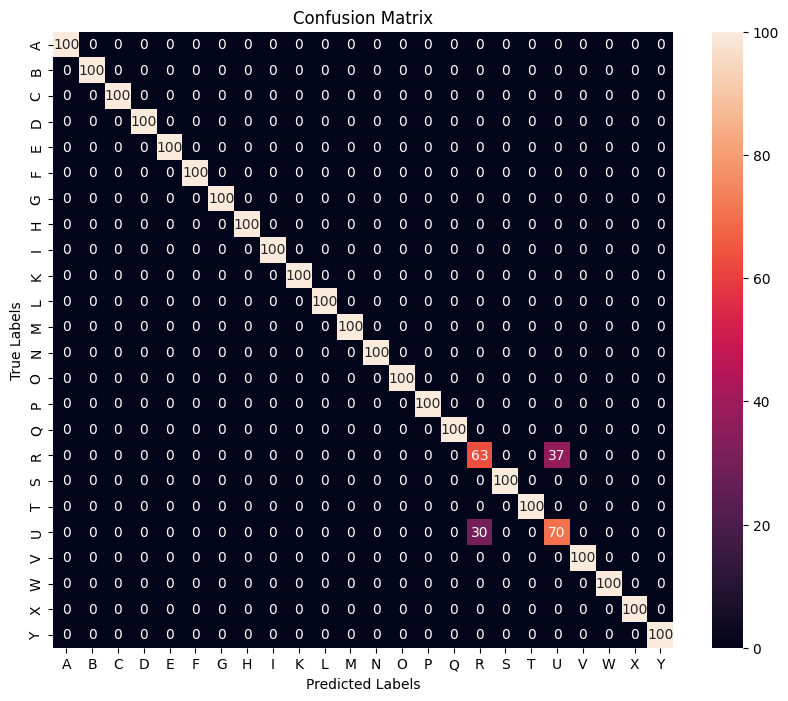

Classification Report
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       100
           B       1.00      1.00      1.00       100
           C       1.00      1.00      1.00       100
           D       1.00      1.00      1.00       100
           E       1.00      1.00      1.00       100
           F       1.00      1.00      1.00       100
           G       1.00      1.00      1.00       100
           H       1.00      1.00      1.00       100
           I       1.00      1.00      1.00       100
           K       1.00      1.00      1.00       100
           L       1.00      1.00      1.00       100
           M       1.00      1.00      1.00       100
           N       1.00      1.00      1.00       100
           O       1.00      1.00      1.00       100
           P       1.00      1.00      1.00       100
           Q       1.00      1.00      1.00       100
           R       0.68      0.63      0.65       100
     

In [118]:
print_confusion_matrix(y_testGood, y_pred_good_max, alphabetical_labels)

# Confusion matrix dark test

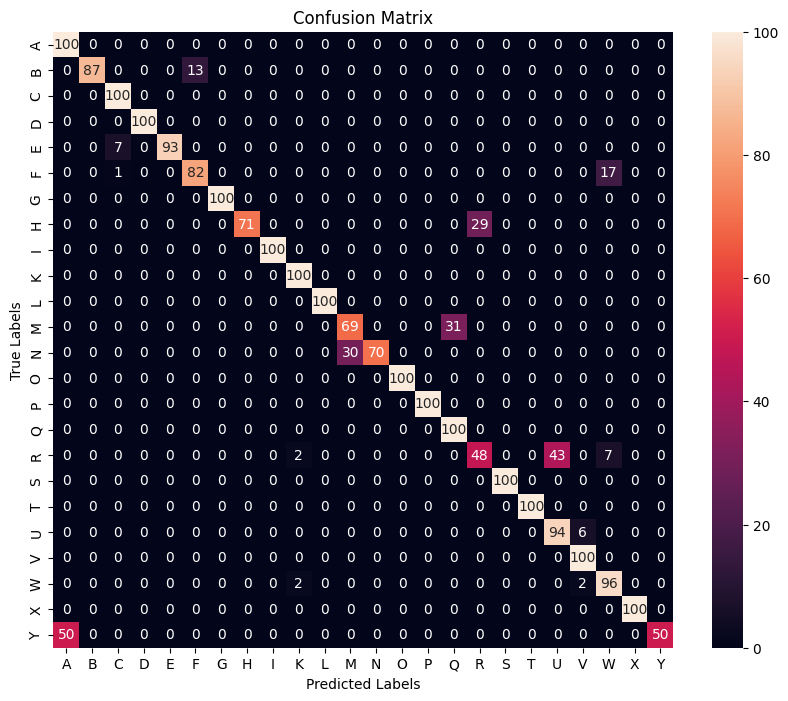

Classification Report
              precision    recall  f1-score   support

           A       0.67      1.00      0.80       100
           B       1.00      0.87      0.93       100
           C       0.93      1.00      0.96       100
           D       1.00      1.00      1.00       100
           E       1.00      0.93      0.96       100
           F       0.86      0.82      0.84       100
           G       1.00      1.00      1.00       100
           H       1.00      0.71      0.83       100
           I       1.00      1.00      1.00       100
           K       0.96      1.00      0.98       100
           L       1.00      1.00      1.00       100
           M       0.70      0.69      0.69       100
           N       1.00      0.70      0.82       100
           O       1.00      1.00      1.00       100
           P       1.00      1.00      1.00       100
           Q       0.76      1.00      0.87       100
           R       0.62      0.48      0.54       100
     

In [119]:
print_confusion_matrix(y_testDark, y_pred_dark_max, labels=alphabetical_labels)

# Confusion matrix occlusion

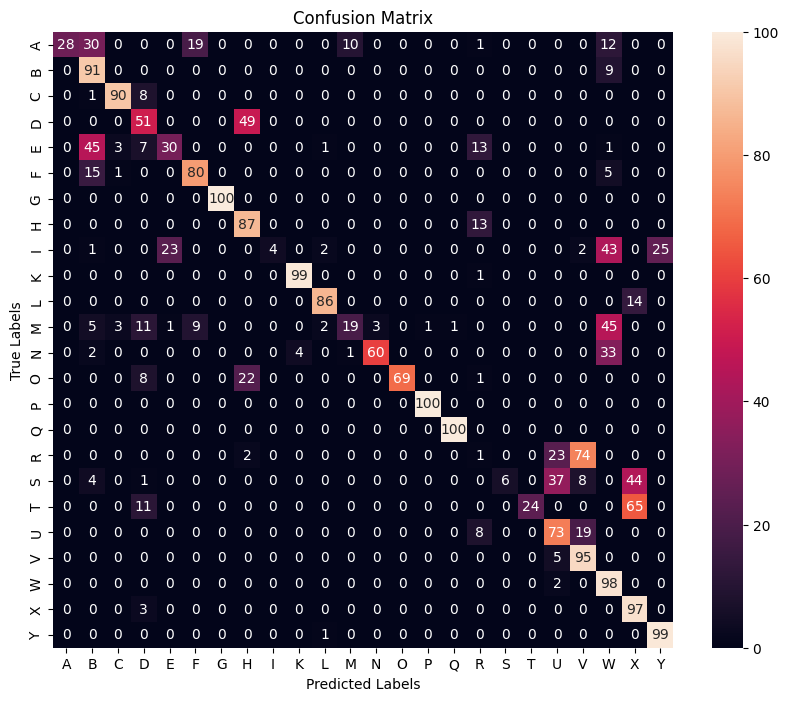

Classification Report
              precision    recall  f1-score   support

           A       1.00      0.28      0.44       100
           B       0.47      0.91      0.62       100
           C       0.93      0.91      0.92        99
           D       0.51      0.51      0.51       100
           E       0.56      0.30      0.39       100
           F       0.74      0.79      0.77       101
           G       1.00      1.00      1.00       100
           H       0.54      0.87      0.67       100
           I       1.00      0.04      0.08       100
           K       0.96      0.99      0.98       100
           L       0.93      0.86      0.90       100
           M       0.63      0.19      0.29       100
           N       0.95      0.60      0.74       100
           O       1.00      0.69      0.82       100
           P       0.99      1.00      1.00       100
           Q       0.99      1.00      1.00       100
           R       0.03      0.01      0.01       100
     

In [120]:
print_confusion_matrix(y_test_hand_behind, y_pred_occlusion_max, labels=alphabetical_labels)

# Convert to model for Tensorflow-Lite

In [88]:
tf.saved_model.save(model, "testkeras")
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

INFO:tensorflow:Assets written to: testkeras\assets


INFO:tensorflow:Assets written to: testkeras\assets


In [89]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

with open(tflite_save_path, 'wb') as f:
    f.write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmp510vtae0\assets


INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmp510vtae0\assets


# Training valication accuracy-loss function

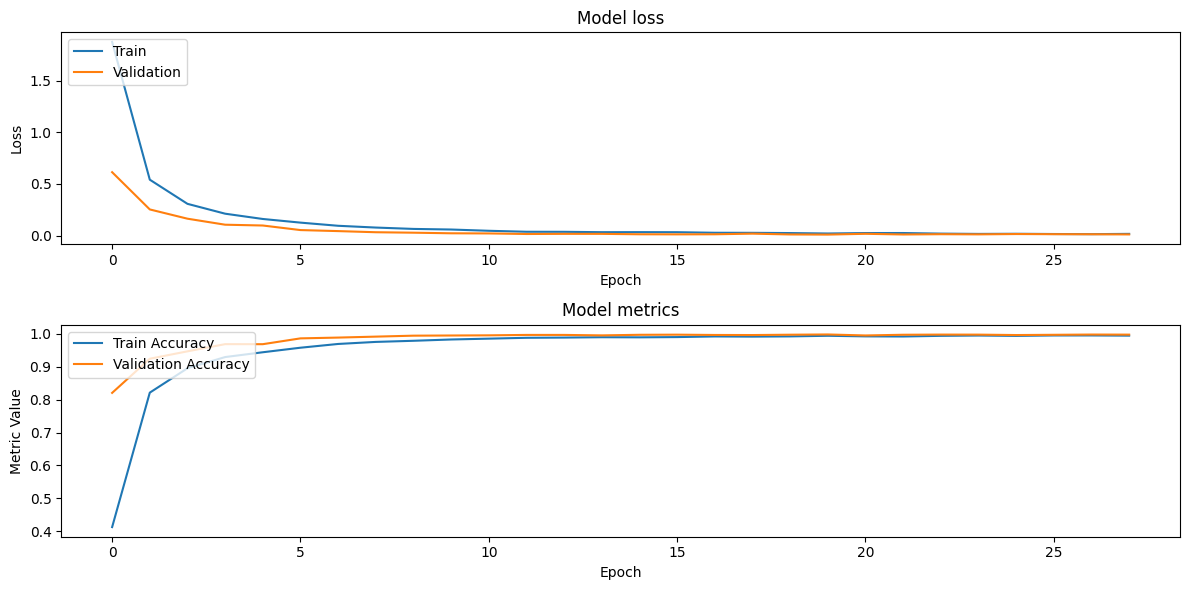

In [90]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy and F1 score values
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'F1 Score'], loc='upper left')

plt.tight_layout()
plt.show()

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Define the labels from A to Y excluding J
alphabetical_labels = [chr(i) for i in range(65, 90) if chr(i) != 'J']

def plot_roc_curves(y_test, y_prob, labels):
    # Binarize the test labels
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curves
    plt.figure()
    colors = plt.cm.get_cmap('tab10', len(classes))

    for i, color in zip(range(len(classes)), colors.colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {labels[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.show()

    # Print sizes
    print("Size of labels:", len(labels))
    print("Size of classes:", len(classes))
    print("Size of roc_auc:", len(roc_auc))

    # Print table of AUC values
    auc_table = pd.DataFrame({'Class': labels, 'AUC': [roc_auc[i] for i in range(len(classes))]})
    print(auc_table)

# ROC curves good test set

C:\Users\joren\AppData\Local\Temp\ipykernel_11924\3549468515.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(classes))


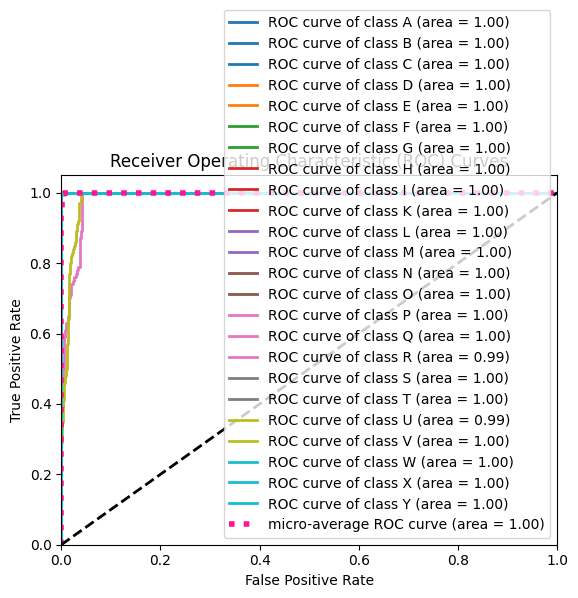

Size of labels: 24
Size of classes: 24
Size of roc_auc: 25
   Class       AUC
0      A  1.000000
1      B  1.000000
2      C  1.000000
3      D  1.000000
4      E  1.000000
5      F  1.000000
6      G  1.000000
7      H  1.000000
8      I  1.000000
9      K  1.000000
10     L  1.000000
11     M  1.000000
12     N  1.000000
13     O  1.000000
14     P  1.000000
15     Q  1.000000
16     R  0.987139
17     S  1.000000
18     T  1.000000
19     U  0.988513
20     V  1.000000
21     W  1.000000
22     X  1.000000
23     Y  1.000000


In [92]:
# Plot ROC curves using the alphabetical labels
plot_roc_curves(y_testGood, y_pred_good, labels=alphabetical_labels)

# ROC curve dark test set

C:\Users\joren\AppData\Local\Temp\ipykernel_11924\3549468515.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(classes))


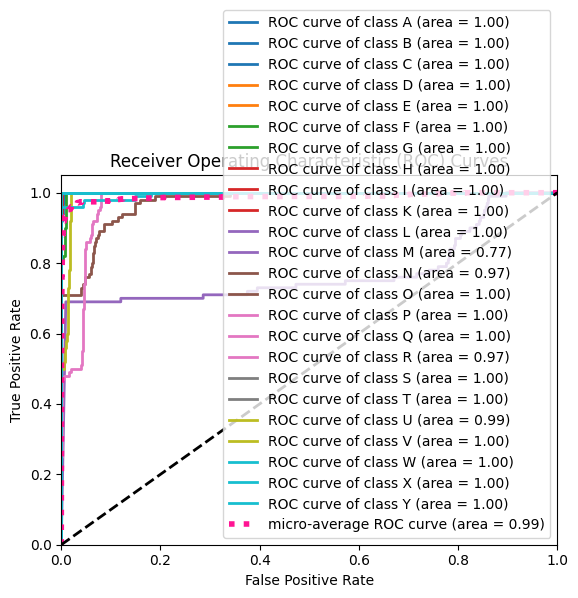

Size of labels: 24
Size of classes: 24
Size of roc_auc: 25
   Class       AUC
0      A  1.000000
1      B  0.999678
2      C  1.000000
3      D  1.000000
4      E  1.000000
5      F  0.998387
6      G  1.000000
7      H  1.000000
8      I  1.000000
9      K  0.999909
10     L  1.000000
11     M  0.772854
12     N  0.972922
13     O  1.000000
14     P  1.000000
15     Q  1.000000
16     R  0.973165
17     S  1.000000
18     T  1.000000
19     U  0.992639
20     V  1.000000
21     W  0.995809
22     X  1.000000
23     Y  1.000000


In [93]:
plot_roc_curves(y_testDark, y_pred_dark, labels = alphabetical_labels)

# ROC curves occlusion test set

C:\Users\joren\AppData\Local\Temp\ipykernel_11924\3549468515.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(classes))


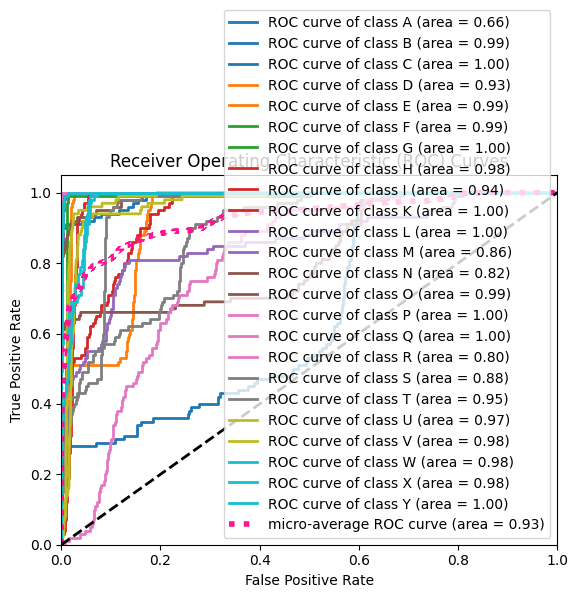

Size of labels: 24
Size of classes: 24
Size of roc_auc: 25
   Class       AUC
0      A  0.655422
1      B  0.989017
2      C  0.999008
3      D  0.925470
4      E  0.985909
5      F  0.987894
6      G  1.000000
7      H  0.976965
8      I  0.940457
9      K  0.999835
10     L  0.998861
11     M  0.860574
12     N  0.822085
13     O  0.990357
14     P  1.000000
15     Q  0.999996
16     R  0.797587
17     S  0.880639
18     T  0.945213
19     U  0.966789
20     V  0.982698
21     W  0.980778
22     X  0.983770
23     Y  0.998909


In [94]:
plot_roc_curves(y_test_hand_behind, y_pred_occlusion, labels = alphabetical_labels)

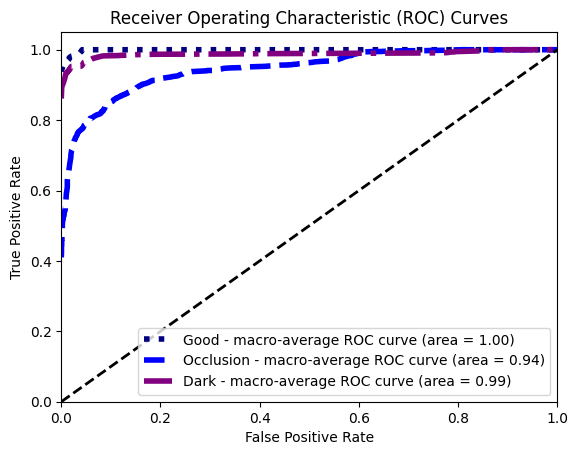

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from numpy import interp
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Define the function to compute ROC curves and AUC
def compute_roc_curves(y_test, y_prob, n_classes):
    # Binarize the test labels
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    return fpr, tpr, roc_auc

# Define the number of classes (assuming all test sets have the same number of classes)
n_classes = len(np.unique(y_testGood))

# Compute ROC curves and AUC for each test set
fpr_good, tpr_good, roc_auc_good = compute_roc_curves(y_testGood, y_pred_good, n_classes)
fpr_occlusion, tpr_occlusion, roc_auc_occlusion = compute_roc_curves(y_test_hand_behind, y_pred_occlusion, n_classes)
fpr_dark, tpr_dark, roc_auc_dark = compute_roc_curves(y_testDark, y_pred_dark, n_classes)

# Plot the average ROC curves for all three test sets
plt.figure()

plt.plot(fpr_good["macro"], tpr_good["macro"],
         label=f'Good - macro-average ROC curve (area = {roc_auc_good["macro"]:0.2f})',
         color='navy', linestyle=':', linewidth=4)

plt.plot(fpr_occlusion["macro"], tpr_occlusion["macro"],
         label=f'Occlusion - macro-average ROC curve (area = {roc_auc_occlusion["macro"]:0.2f})',
         color='blue', linestyle='--', linewidth=4)

plt.plot(fpr_dark["macro"], tpr_dark["macro"],
         label=f'Dark - macro-average ROC curve (area = {roc_auc_dark["macro"]:0.2f})',
         color='purple', linestyle='-.', linewidth=4)

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

In [103]:
import time

val_loss, val_acc = model.evaluate(X_testGood, y_testGood, batch_size = 8)
startTime = time.time()
model.predict(X_testGood[0:1])
stopTime = time.time()
print("Predict time: ", stopTime - startTime, " seconds")

1/1 [==============================] - 0s 33ms/step
Predict time:  0.09594345092773438  seconds
